## <font color=purple>Import needed modules</font>

In [1]:
#general libraries needed
import pandas as pd
import numpy as np

# for plotting 
import matplotlib.pyplot as plt
from matplotlib import cm

#scikit learn modules
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## <font color=purple>Function Definitions</font>

In [2]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [3]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [4]:
#function to create a 2 dimmensional representation of data using tSNE
def tsne_plot(X, y):
    X_tsne = TSNE(learning_rate=1000, perplexity=25, init="random").fit_transform(X)
    plt.figure(1, facecolor='white', figsize=(10, 12))
    a=plt.scatter(
        X_tsne[(y!=-1), 0],
        X_tsne[(y!=-1), 1],
        s=100,
        alpha=0.90,
        c=y[y!=-1],
        cmap=cm.Paired
    )
    plt.legend(handles=a.legend_elements()[0],labels=a.legend_elements()[1])
    plt.scatter(
        X_tsne[(y==-1), 0],
        X_tsne[(y==-1), 1],
        s=100,
        alpha=0.05
    )
    plt.title('T-SNE Plot')
    plt.show()

## <font color=purple>Source Data

In [5]:
#download data files if not currently downloaded into the current working directory
path = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename = "sephora_website_dataset.csv"


path2 = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename2 = "product_info.csv"


downloadDataResource(filename, path)
downloadDataResource(filename2, path2)

Data resource sephora_website_dataset.csv already downloaded.
Data resource product_info.csv already downloaded.


In [6]:
#create a dataframe with the data from the CSV file
df = pd.read_csv(filename)
df2 = pd.read_csv(filename2)

## <font color=purple>Transform Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168 entries, 0 to 9167
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9168 non-null   int64  
 1   brand                   9168 non-null   object 
 2   category                9168 non-null   object 
 3   name                    9168 non-null   object 
 4   size                    9168 non-null   object 
 5   rating                  9168 non-null   float64
 6   number_of_reviews       9168 non-null   int64  
 7   love                    9168 non-null   int64  
 8   price                   9168 non-null   float64
 9   value_price             9168 non-null   float64
 10  URL                     9168 non-null   object 
 11  MarketingFlags          9168 non-null   bool   
 12  MarketingFlags_content  9168 non-null   object 
 13  options                 9168 non-null   object 
 14  details                 9168 non-null   

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [9]:
df2.rename(columns = {'product_name':'name'}, inplace = True)
#df2.rename(columns = {'rating':'2023ratings'}, inplace = True)

In [10]:
df["cat_rating"] = ["3.5" if x < 4.0 else "4.0" if x == 4.0 else "4.5" if x == 4.5 else "5" for x in df["rating"]]

In [11]:
df = pd.merge(df,df2[['name',"secondary_category"]],on='name', how='left')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9232 entries, 0 to 9231
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9232 non-null   int64  
 1   brand                   9232 non-null   object 
 2   category                9232 non-null   object 
 3   name                    9232 non-null   object 
 4   size                    9232 non-null   object 
 5   rating                  9232 non-null   float64
 6   number_of_reviews       9232 non-null   int64  
 7   love                    9232 non-null   int64  
 8   price                   9232 non-null   float64
 9   value_price             9232 non-null   float64
 10  URL                     9232 non-null   object 
 11  MarketingFlags          9232 non-null   bool   
 12  MarketingFlags_content  9232 non-null   object 
 13  options                 9232 non-null   object 
 14  details                 9232 non-null   

In [13]:
df.head()

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer,cat_rating,secondary_category
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0,4.0,NaN
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0,4.5,Men
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0,4.5,Women
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0,4.5,Women
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0,3.5,NaN


In [14]:
df.name.str.split().explode().value_counts().head(10)

Mini     665
&        629
Cream    530
Set      464
Lip      404
Mask     402
de       400
Eau      400
Brush    393
Oil      387
Name: name, dtype: int64

In [15]:
df["mini"] = [1 if "Mini" in x else 0 for x in df["name"]]
df["cream"] = [1 if "Cream" in x else 0 for x in df["name"]]
df["set"] = [1 if "Set" in x else 0 for x in df["name"]]
df["mask"] = [1 if "Mask" in x else 0 for x in df["name"]]
df["eau"] = [1 if "Eau" in x else 0 for x in df["name"]]
df["lip"] = [1 if "Lip" in x else 0 for x in df["name"]]
df["brush"] = [1 if "Brush" in x else 0 for x in df["name"]]
df["oil"] = [1 if "Oil" in x else 0 for x in df["name"]]

In [16]:
df.ingredients.str.split().explode().value_counts().head(20)

Extract-         17337
the              17179
that             14600
of               14080
and              13214
Oil-             12294
Sodium           11416
(Ci              11147
-                10386
to               10238
Glycol-           7869
Acid-             7759
Seed              7295
or                7005
are               6973
is                6933
methacrylate-     6591
Ci                5710
be                5522
products          5429
Name: ingredients, dtype: int64

In [17]:
df["extract"] = [1 if "Extract-" in x else 0 for x in df["ingredients"]]
df["oil"] = [1 if "Oil- " in x else 0 for x in df["ingredients"]]
df["sodium"] = [1 if "Sodium" in x else 0 for x in df["ingredients"]]
df["glycol"] = [1 if "Glycol-" in x else 0 for x in df["ingredients"]]
df["acid"] = [1 if "Acid-" in x else 0 for x in df["ingredients"]]
df["seed"] = [1 if "Seed" in x else 0 for x in df["ingredients"]]
df["metha"] = [1 if "methacrylate- " in x else 0 for x in df["ingredients"]]

In [18]:
toPredict = df.loc[(df['name'] == 'Green Clean Makeup Removing Cleansing Balm') 
                   | (df['name'] == 'Glowscreen Sunscreen SPF 40')
                  | (df['name'] == 'Wisteria & Lavender Cologne')]

In [19]:
df = df[df.name != 'Green Clean Makeup Removing Cleansing Balm']
df = df[df.name != 'Glowscreen Sunscreen SPF 40']
df = df[df.name != 'Wisteria & Lavender Cologne']

In [20]:
df = df.drop(columns = ["id","rating","name","size","value_price","URL","MarketingFlags","MarketingFlags_content","options","details","how_to_use","ingredients"])

In [21]:
toPredict=toPredict.drop(columns=["id","rating","name","size","value_price","URL","MarketingFlags","MarketingFlags_content","options","details","how_to_use","ingredients","cat_rating"])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9229 entries, 0 to 9231
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brand               9229 non-null   object 
 1   category            9229 non-null   object 
 2   number_of_reviews   9229 non-null   int64  
 3   love                9229 non-null   int64  
 4   price               9229 non-null   float64
 5   online_only         9229 non-null   int64  
 6   exclusive           9229 non-null   int64  
 7   limited_edition     9229 non-null   int64  
 8   limited_time_offer  9229 non-null   int64  
 9   cat_rating          9229 non-null   object 
 10  secondary_category  2467 non-null   object 
 11  mini                9229 non-null   int64  
 12  cream               9229 non-null   int64  
 13  set                 9229 non-null   int64  
 14  mask                9229 non-null   int64  
 15  eau                 9229 non-null   int64  
 16  lip   

### Create Training and Test data sets

In [23]:
X_train_pre, X_test_pre, y_train, y_test = train_test_split(
    df.drop(columns=['cat_rating']),
    df['cat_rating'],
    test_size=0.2,
    random_state=34
)    
X_train_pre.shape,X_test_pre.shape,y_train.shape, y_test.shape 

((7383, 24), (1846, 24), (7383,), (1846,))

### Prepare Data

In [24]:
cat_attribs = ["brand", "category","secondary_category"]

#set the numerical attributes
num_attribs = list( X_train_pre.drop(cat_attribs,axis=1) )

num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), #because no missing values, not used
 ('std_scaler', StandardScaler()),   
])

#define the column transformation process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse = False), cat_attribs)      #because no categorical attributes, not used 
])

In [25]:
#diagram pipeline process (NOTE this only works because of the import and set statement at the top)
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['number_of_reviews', 'love', 'price',
                                  'online_only', 'exclusive', 'limited_edition',
                                  'limited_time_offer', 'mini', 'cream', 'set',
                                  'mask', 'eau', 'lip', 'brush', 'oil',
                                  'extract', 'sodium', 'glycol', 'acid', 'seed',
                                  'metha']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['brand', 'category', 'secondary_category'])])

In [26]:
full_pipeline.fit(df)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['number_of_reviews', 'love', 'price',
                                  'online_only', 'exclusive', 'limited_edition',
                                  'limited_time_offer', 'mini', 'cream', 'set',
                                  'mask', 'eau', 'lip', 'brush', 'oil',
                                  'extract', 'sodium', 'glycol', 'acid', 'seed',
                                  'metha']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['brand', 'category', 'secondary_category'])])

In [27]:
#create an array of prepared data based on the training data set
X_train = full_pipeline.transform( X_train_pre )
X_train.shape

(7383, 529)

In [28]:
#create an array of prepared data based on the test data set
X_test = full_pipeline.transform( X_test_pre)
X_test.shape

(1846, 529)

## <font color=purple>Logistic Regression Model

In [29]:
# Train the logistic regression model
log_reg = LogisticRegression(multi_class='multinomial')

#fit the model to the training data
log_reg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [30]:
#calculated the accuracy (i.e. predicted vs. actual for the test data set)
acc = log_reg.score(X_train, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 53.89%


In [31]:
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
scores.mean()
print('Accuracy: {:.2f}%'.format(scores.mean()*100))

Accuracy: 45.39%


In [32]:
#calculated the accuracy (i.e. predicted vs. actual for the test data set)
acc = log_reg.score(X_test, y_test)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 46.10%


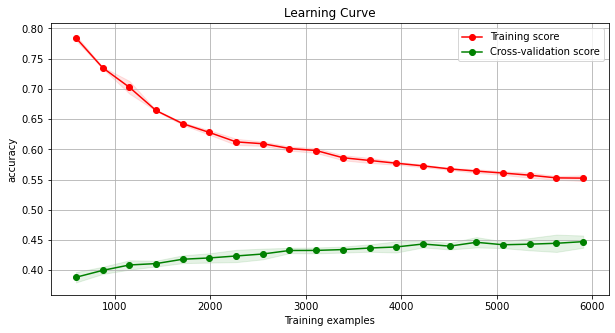

In [33]:
plot_learning_curve(log_reg, X_train, y_train, scoring='accuracy')

## <font color=purple>PCA Analysis

In [34]:
X_train.shape

(7383, 529)

In [35]:
pca = PCA(n_components=.95)
X_train_reduced = pca.fit_transform(X_train)
X_train_reduced.shape

(7383, 70)

In [36]:
X_test_reduced = pca.transform(X_test)

In [37]:
X_test_reduced.shape

(1846, 70)

# Predictions

In [38]:
X_prepared=full_pipeline.transform(toPredict)
log_reg.predict(X_prepared)

array(['4.5', '4.0', '4.0'], dtype=object)

## <font color=purple>Logistic Regression Model with PCA

In [39]:
# Train the logistic regression model
log_reg = LogisticRegression(multi_class='multinomial')

log_reg.fit(X_train_reduced, y_train)

LogisticRegression(multi_class='multinomial')

In [40]:
#calculated the accuracy (i.e. predicted vs. actual for the training data set)
acc = log_reg.score(X_train_reduced, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 46.34%


In [41]:
scores = cross_val_score(log_reg, X_train_reduced, y_train, cv=10)
scores.mean()
print('Accuracy: {:.2f}%'.format(scores.mean()*100))

Accuracy: 44.10%


In [42]:
#calculated the accuracy (i.e. predicted vs. actual for the test data set)
acc = log_reg.score(X_test_reduced, y_test)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 45.67%


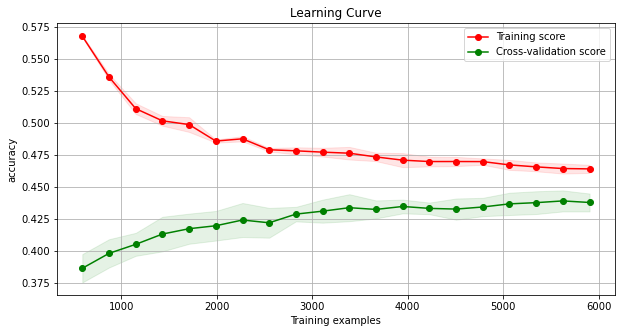

In [43]:
plot_learning_curve(log_reg, X_train_reduced, y_train, scoring="accuracy")

In [44]:
toPredict.head()

,brand,category,number_of_reviews,love,price,online_only,exclusive,limited_edition,limited_time_offer,secondary_category,...,eau,lip,brush,oil,extract,sodium,glycol,acid,seed,metha
2801,Farmacy,Face Wash & Cleansers,3000,195000,34.0,0,1,0,0,Cleansers,...,0,0,0,1,1,0,1,1,1,1
4053,Jo Malone London,Perfume,6,2300,72.0,0,0,1,0,NaN,...,0,0,0,0,0,0,0,0,0,0
7828,Supergoop!,Face Sunscreen,158,25400,36.0,0,0,0,0,NaN,...,0,0,0,1,1,1,1,1,1,1
